# Initialization through BNSE for SM kernel

Comparison between initializing sm kernel with different heuristics

* Random (See Andrew Wilson PHD thesis)
* Lomb Scargle
* BNSE


To-DO:
    * Quadratic detrend ????

In [1]:
# import library if it is not installed
import sys
sys.path.insert(0, '../')

import mogptk
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.signal import detrend

%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
def get_param_across(model, name='mixture_means'):
    """
    Get all the name parameters across all components
    """
    params = [model.get_params()[q][name] for q in range(model.Q)]
    
    return np.array(params)

In [4]:
def plot_psd(model):
    """
    Plot power spectral density of 
    single output GP-SM
    """
    means = get_param_across(model, 'mixture_means').reshape(-1)
    weights = get_param_across(model, 'mixture_weights').reshape(-1)
    scales = get_param_across(model, 'mixture_scales').reshape(-1)
    
    # calculate bounds
    x_low = norm.ppf(0.001, loc=means, scale=scales).min()
    x_high = norm.ppf(0.99, loc=means, scale=scales).max()
    
    x = np.linspace(x_low, x_high + 1, 1000)
    psd = np.zeros_like(x)
    
    for q in range(model.Q):
        single_psd = weights[q] * norm.pdf(x, loc=means[q], scale=scales[q])
        plt.plot(x, single_psd, '--', lw=1.2, c=sns.color_palette()[3], zorder=2)
        plt.axvline(means[q], ymin=0.001, ymax=0.1, lw=2, color='grey')
        psd = psd + single_psd
        
    # symmetrize PSD
    if psd[x<0].size != 0:
        psd = psd + np.r_[psd[x<0][::-1], np.zeros((x>=0).sum())]
        
    plt.plot(x, psd, lw=2.5, c='r', alpha=0.7, zorder=1)
    plt.xlim(0, x[-1] + 0.1)
    # plt.yscale('log')
    plt.xlabel(r'$\omega$')
    plt.ylabel('PSD')

In [16]:
def experiment(x_train, y_train, x_pred, y_test, true_means, Q=3, n_trials=100):
    """
    Experiment with the 3 initializations for GP-SM
    
    The GP is fitted using the data and compared with the real
    parameters. This is done 'n_trial' times for each initialization 
    method.
    """
    # total error
    mae_param = np.zeros((3, n_trials))
    mae_pred = np.zeros((3, n_trials))
    
    x_pred = {0:x_pred.reshape(-1, 1)}
    
    # create and train model
    data = mogptk.Data()
    data.add(x_train, y_train)
    
    init_methods = ['random', 'LS', 'BNSE']
    
    for i, method in enumerate(init_methods):
        for n in range(n_trials):
            # pick random seed
            seed = np.random.randint(1, int(1e8))
            np.random.seed(seed)
            
            model = mogptk.SM(data, Q=Q)
            model.init_params(method)
            model.train(maxiter=5000, disp=False)
            
            # param error
            means_pred = get_param_across(model, 'mixture_means').reshape(-1)
            mae_param[i, n] = np.abs(true_means - means_pred).sum()
            
            # pred error
            _, y_pred, var_pred = model.predict(x_pred)
            mae_pred[i, n] = np.abs(y_test - y_pred[0]).mean()
            
    return mae_param, mae_pred

Create data for the experiment

In [17]:
# target freq to estimate
target_freqs = np.array([0.2, 1, 2])
target_amps = [1, 0.5, 0.5]

n_points = 500

t = np.linspace(0, 20, n_points)
y = np.zeros(n_points)

for i in range(3):
    y += target_amps[i] * np.sin(2 * np.pi * target_freqs[i] * t)
y_n = y + np.random.normal(scale=0.1, size=500)

# data class
data = mogptk.Data()

data.add(t, y_n, 0)
data.remove_range(0, start=10.0, end=None)

Mixture means [[1.00008521]
 [0.83928925]
 [1.18107585]]
Mixture weights [0.04829105 0.48082885 1.05601897]


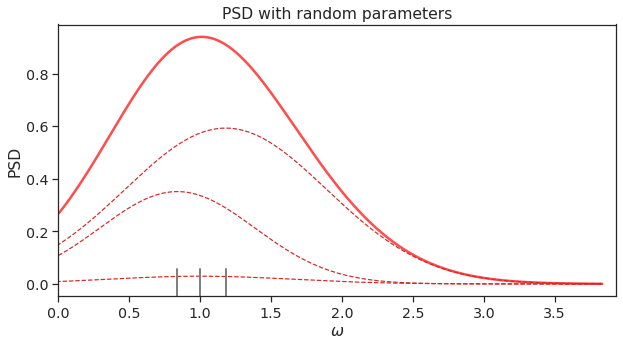

In [18]:
# create model
model = mogptk.SM(data, Q=3)

print('Mixture means', get_param_across(model))
print('Mixture weights', get_param_across(model, 'mixture_weights'))

plot_psd(model)
plt.title('PSD with random parameters');

Mixture means [0.1997998 0.998999  1.997998 ]
Mixture scales [0.22078245 0.11876476 0.16110531]
Mixture weights [0.49539687 0.60988398 0.61856566]


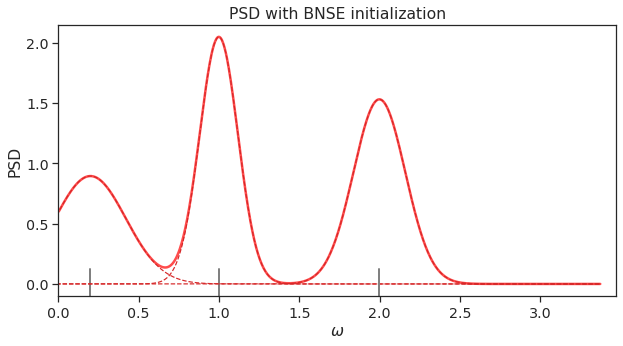

In [27]:
seed = np.random.randint(1, int(1e8))
np.random.seed(seed)

# initialize params
method = 'BNSE'
model.init_params(method=method)
# display(model.get_params())
print('Mixture means', get_param_across(model).reshape(-1))
print('Mixture scales', get_param_across(model, 'mixture_scales').reshape(-1))
print('Mixture weights', get_param_across(model, 'mixture_weights'))

plot_psd(model)
plt.title('PSD with {} initialization'.format(method));

3 1 (3,) (3, 1) (1, 3)
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -208.040658
  Number of iterations: 131
  Number of functions evaluations: 168
Mixture means [0.19968584 1.00123013 2.0010484 ]


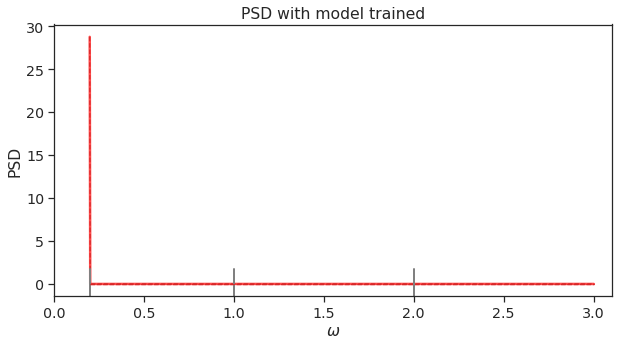

In [28]:
model.train(method='L-BFGS-B', maxiter=6000, disp=False)
plot_psd(model)
plt.title('PSD with model trained')
print('Mixture means', get_param_across(model).reshape(-1))

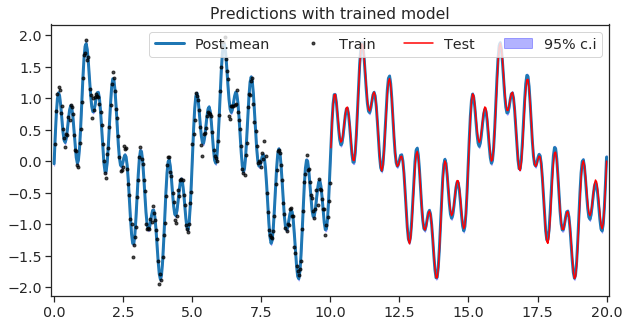

In [29]:
# x_pred = {0:np.linspace(0, 20, 300)}
x_pred = {0:t.reshape(-1, 1)}
x_pred, y_pred, y_var = model.predict(x_pred)

plt.plot(x_pred[0], y_pred[0], label='Post.mean', lw=3, zorder=2)
plt.plot(data.X[0], data.Y[0], '.k', alpha=0.7, zorder=2, label='Train')
plt.plot(t[250:], y[250:], 'r', zorder=3, label='Test')
plt.fill_between(x_pred[0],
                 y_pred[0] + 2 * np.sqrt(y_var[0]), 
                y_pred[0] - 2 * np.sqrt(y_var[0]),
                 color='b',
                alpha=0.3,
                zorder=1,
                label='95% c.i')
plt.xlim(-0.1, 20.1)
plt.legend(ncol=4)
plt.title('Predictions with trained model');

In [30]:
err_param, err_pred = experiment(t[:250], y_n[:250], t, y, target_freqs, Q=3, n_trials=10)

3 1 (3,) (3, 1) (1, 3)
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.654553
  Number of iterations: 78
  Number of functions evaluations: 107
3 1 (3,) (3, 1) (1, 3)
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -69.640202
  Number of iterations: 48
  Number of functions evaluations: 62
3 1 (3,) (3, 1) (1, 3)
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 203.455896
  Number of iterations: 31
  Number of functions evaluations: 37
3 1 (3,) (3, 1) (1, 3)
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -133.526248
  Number of iterations: 80
  Number of functions evaluations: 107
3 1 (3,) (3, 1) (1, 3)
INFO:tensorflow:Optimization termi

In [31]:
err_param.mean(1), err_param.std(1)

(array([10.09997061,  2.08070354,  0.2022972 ]),
 array([4.42227011, 0.56015526, 0.5992847 ]))

In [32]:
err_pred.mean(1), err_pred.std(1)

(array([0.48432602, 0.05576698, 0.02309033]),
 array([1.12175372e-01, 9.80180744e-02, 1.02478898e-05]))


# Experiment 1: Mauna Loa

In [33]:
# dataset mauna loa
from sklearn.datasets import fetch_openml

def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

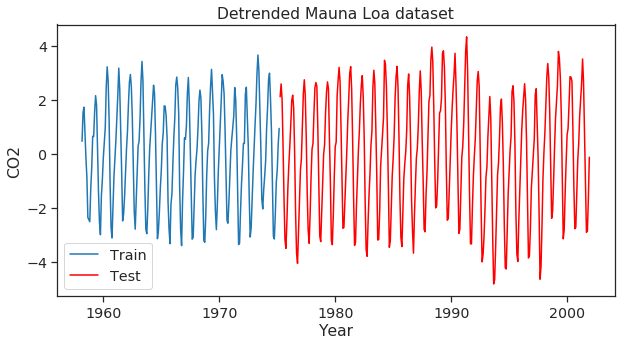

In [34]:
x, y_old = load_mauna_loa_atmospheric_co2()

# detrend 
poly = np.polyfit(x, y_old, 3)
y = y_old - np.polyval(poly, x)
# y = detrend(y_old, axis=-1, type='linear')

trend = y_old - y
stop = 200

plt.plot(x[:stop], y[:stop], label='Train')
plt.plot(x[stop:], y[stop:], 'r', label='Test')
plt.legend()
plt.xlabel('Year')
plt.ylabel('CO2');
plt.title('Detrended Mauna Loa dataset');

Mixture means [[1.08724261]
 [0.92677241]
 [0.86920718]
 [0.39452967]
 [0.4488877 ]
 [1.44284673]
 [0.19432627]
 [0.08846263]
 [0.91925118]
 [0.62608685]]
Mixture weights [0.58043253 0.73102968 0.13428581 2.3559109  0.85150592 2.15873989
 0.84413738 2.57147706 0.95487133 0.3822313 ]


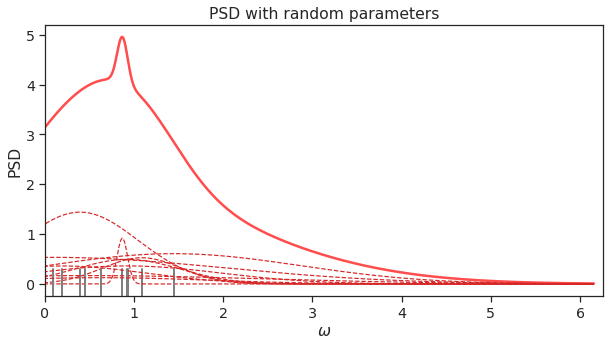

In [38]:
# add data
data = mogptk.Data()
data.add(x[:stop, np.newaxis], y[:stop])

# create model
model = mogptk.SM(data, Q=10)

plot_psd(model)
plt.title('PSD with random parameters');

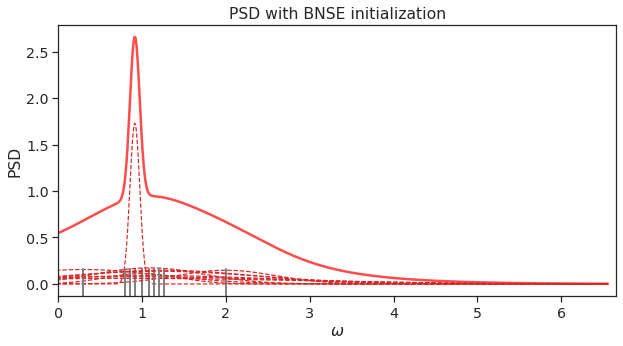

In [39]:
method = 'BNSE'

# model.init_params('random')
model.init_params(method)
plt.title('PSD with {} initialization'.format(method));
plot_psd(model)

10 1 (10,) (10, 1) (1, 10)
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: 53.903837
  Number of iterations: 192
  Number of functions evaluations: 285
CPU times: user 1.65 s, sys: 232 ms, total: 1.88 s
Wall time: 1.59 s


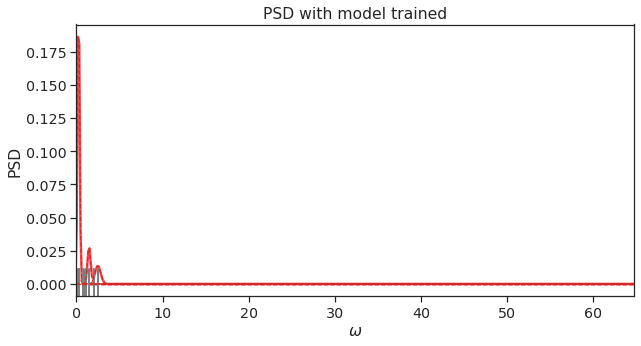

In [40]:
%%time 
model.train(method='BFGS', maxiter=1000, disp=False, learning_rate=0.001)

plot_psd(model)
plt.title('PSD with model trained');

CPU times: user 84 ms, sys: 4 ms, total: 88 ms
Wall time: 87.2 ms


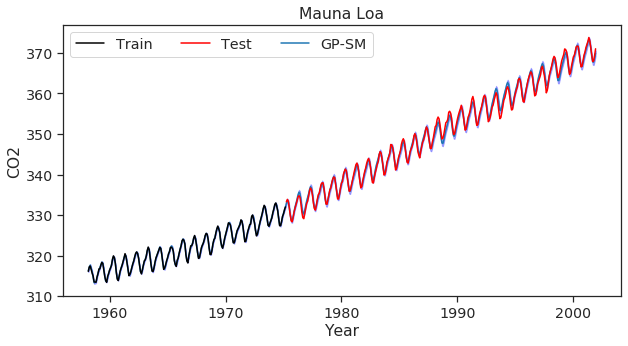

In [49]:
%%time 

# prediction
x_pred = {0:x[:, np.newaxis]}

x_pred, y_pred, y_var = model.predict(x_pred)

# plot
plt.plot(x[:stop], trend[:stop] + y[:stop], '-k', label='Train')
plt.plot(x[stop:], trend[stop:] + y[stop:], '-r', label='Test')
plt.plot(x_pred[0], trend + y_pred[0], lw=1.5, zorder=1, label='GP-SM')
plt.fill_between(x_pred[0].reshape(-1),
                 trend + y_pred[0] + 2 * np.sqrt(y_var[0]),
                 trend + y_pred[0] - 2 * np.sqrt(y_var[0]),
                 color='b',
                 alpha=0.3,
                 zorder=1)
plt.legend(ncol=3)
plt.title('Mauna Loa')
plt.xlabel('Year')
plt.ylabel('CO2')

In [ ]:
true_means = np.zeros(model.Q)
err_param, err_pred = experiment(x[:stop], y[:stop], x, y, true_means, Q=model.Q, n_trials=20)

In [ ]:
err_pred.mean(1), err_pred.std(1)

# Jura single output


Save for later (until multi input)

In [ ]:
jura = pd.read_csv('data/jura.csv')

In [ ]:
jura.head()

# Airplane passangers

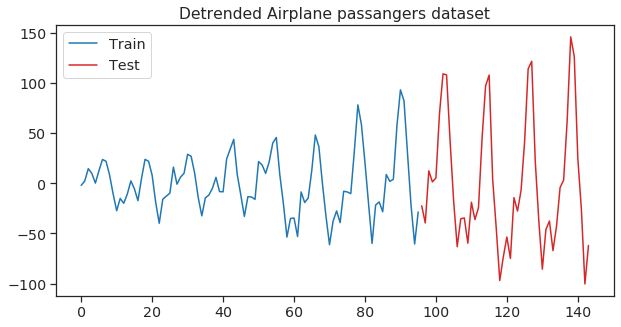

In [50]:
air = np.loadtxt('data/Airline_passenger.csv')

stop = 96

x = air[: ,0]
y_old = air[:, 1]

# detrend
poly = np.polyfit(x, y_old, 2)
y = y_old - np.polyval(poly, x)

data = mogptk.Data()
data.add(x[:stop], y[:stop])

plt.plot(data.X[0], data.Y[0], label='Train')
plt.plot(x[stop:], y[stop:], c=sns.color_palette()[3], label='Test')
plt.title('Detrended Airplane passangers dataset')
plt.legend()

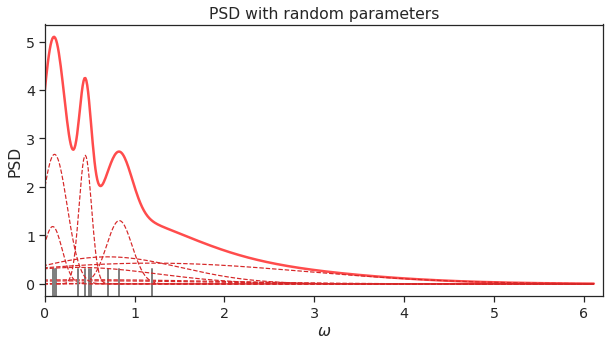

In [51]:
model = mogptk.SM(data, Q=10)
plot_psd(model)

plt.title('PSD with random parameters');

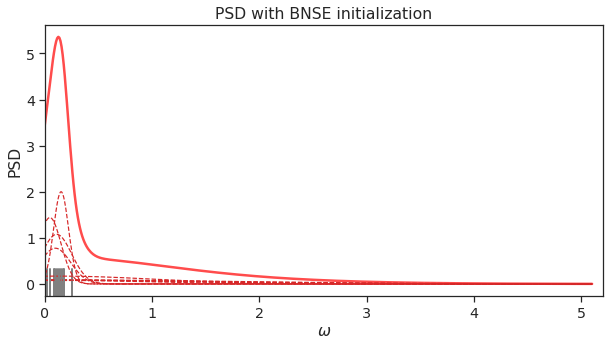

In [52]:
method = 'BNSE'
model.init_params(method)
plot_psd(model)
plt.title('PSD with {} initialization'.format(method));

Building...
10 1 (10,) (10, 1) (1, 10)
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 403.678747
  Number of iterations: 91
  Number of functions evaluations: 136
Done


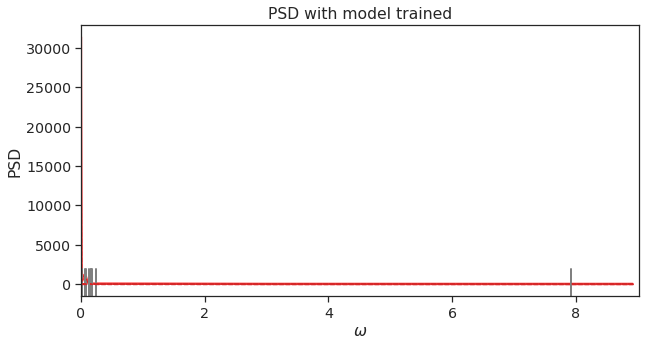

In [53]:
model.train('L-BFGS-B', maxiter=5000)
plot_psd(model)
plt.title('PSD with model trained');

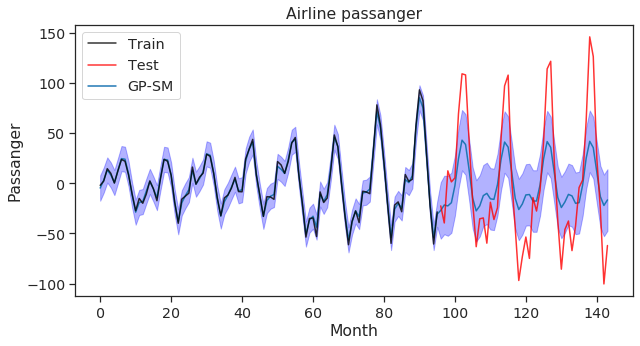

In [55]:
x_pred = {0:x[:, np.newaxis]}
x_pred, y_pred, y_var = model.predict(x_pred)

# plot
plt.plot(x[:stop], y[:stop], '-k', label='Train', alpha=0.8)
plt.plot(x[stop:], y[stop:], '-r', label='Test', alpha=0.8)
plt.plot(x_pred[0], y_pred[0], lw=1.5, zorder=1, label='GP-SM')
plt.fill_between(x_pred[0].reshape(-1),
                 y_pred[0] + 2 * np.sqrt(y_var[0]),
                y_pred[0] - 2 * np.sqrt(y_var[0]),
                 color='b',
                alpha=0.3,
                zorder=1)
plt.title('Airline passanger')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Passanger');